# Getting Started - RocketPy in Coab

We start by setting up our environment. To run this notebook, we will need:


*   RocketPy
*   netCDF4 (to get weather forecasts)
*   Data files (we will clone RocketPy's repository for these)

Therefore, let's run the following lines of code:

In [1]:
!pip install rocketpy netCDF4
!git clone https://github.com/giovaniceotto/RocketPy.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
fatal: destination path 'RocketPy' already exists and is not an empty directory.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os

os.chdir("RocketPy/docs/notebooks")

Now we can start!

Here we go through a simplified rocket trajectory simulation to get you started. Let's start by importing the rocketpy module.

In [4]:
from rocketpy import Environment, SolidMotor, Rocket, Flight

If you are using Jupyter Notebooks, it is recommended to run the following line to make matplotlib plots which will be shown later interactive and higher quality.

In [5]:
%config InlineBackend.figure_formats = ['svg']
%matplotlib inline

## Setting Up a Simulation

### Creating an Environment for Spaceport America

In [6]:
Env = Environment(
    railLength=3.66, latitude=35.176307, longitude=-76.826296, elevation=10
)

To get weather data from the GFS forecast, available online, we run the following lines.

First, we set tomorrow's date.

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/RocketPy/docs/notebooks
Launch Site Details

Launch Rail Length: 3.66  m
Launch Date: 2023-02-26 00:00:00 UTC
Launch Site Latitude: 35.14310°
Launch Site Longitude: -76.81260°
Reference Datum: SIRGAS2000
Launch Site UTM coordinates: 334876.35 W    3890416.26 N
Launch Site UTM zone: 17S
Launch Site Surface Elevation: 11.0 m


Atmospheric Model Details

Atmospheric Model Type: WyomingSounding
WyomingSounding Maximum Height: 34.111 km


Surface Atmospheric Conditions

Surface Wind Speed: 2.57 m/s
Surface Wind Direction: 350.00°
Surface Wind Heading: 170.00°
Surface Pressure: 1018.00 hPa
Surface Temperature: 280.95 K
Surface Air Density: 1.262 kg/m³
Surface Speed of Sound: 336.02 m/s


Atmospheric Model Plots


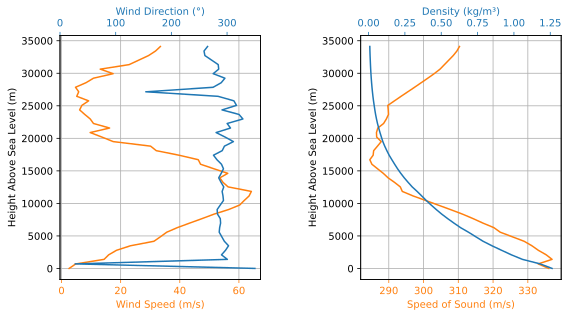

Launch Site Details

Launch Rail Length: 3.66  m
Launch Date: 2023-02-26 00:00:00 UTC
Launch Site Latitude: 35.14310°
Launch Site Longitude: -76.81260°
Reference Datum: SIRGAS2000
Launch Site UTM coordinates: 334876.35 W    3890416.26 N
Launch Site UTM zone: 17S
Launch Site Surface Elevation: 5.0 m


Atmospheric Model Details

Atmospheric Model Type: CustomAtmosphere
CustomAtmosphere Maximum Height: 1.000 km


Surface Atmospheric Conditions

Surface Wind Speed: 8.90 m/s
Surface Wind Direction: 180.00°
Surface Wind Heading: 0.00°
Surface Pressure: 1012.65 hPa
Surface Temperature: 288.12 K
Surface Air Density: 1.224 kg/m³
Surface Speed of Sound: 340.27 m/s


Atmospheric Model Plots


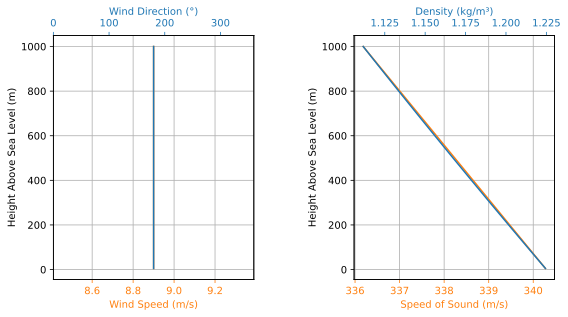

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from rocketpy import Environment,Rocket,SolidMotor,Flight
from mpl_toolkits import mplot3d
import datetime
from rocketpy.EnvironmentAnalysis import EnvironmentAnalysis
import os
from google.colab import drive
drive.mount('/content/drive')
print(os.getcwd())

# This one is able to view events in the past, others you have to download .nc files to view
EnvWUAS= Environment(
    railLength=3.66,
    latitude=35.1431,
    longitude=-76.8126,
    elevation=5,
    date=(2023, 2, 26),
)

URL = "http://weather.uwyo.edu/cgi-bin/sounding?region=naconf&TYPE=TEXT%3ALIST&YEAR=2023&MONTH=02&FROM=2612&TO=2618&STNM=72305"

EnvWUAS.setAtmosphericModel(type="WyomingSounding", file=URL)

Env20 = Environment(
    railLength=3.66,
    latitude=35.1431,
    longitude=-76.8126,
    elevation=5,
    date=(2023, 2, 26),
    
)
Env20.setAtmosphericModel(type="CustomAtmosphere", wind_v=8.9)

EnvWUAS.info()
Env20.info()

In [8]:
import datetime

tomorrow = datetime.date.today() + datetime.timedelta(days=1)

Env.setDate((tomorrow.year, tomorrow.month, tomorrow.day, 18))  # Hour given in UTC time

Then, we tell Env to use a GFS forecast to get the atmospheric conditions for flight.

Don't mind the warning, it just means that not all variables, such as wind speed or atmospheric temperature, are available at all altitudes given by the forecast.

In [9]:
Env.setAtmosphericModel(type="Forecast", file="GFS")

We can see what the weather will look like by calling the info method!

Launch Site Details

Launch Rail Length: 3.66  m
Launch Date: 2023-03-07 18:00:00 UTC
Launch Site Latitude: 35.17631°
Launch Site Longitude: -76.82630°
Reference Datum: SIRGAS2000
Launch Site UTM coordinates: 333696.17 W    3894122.34 N
Launch Site UTM zone: 17S
Launch Site Surface Elevation: 8.7 m


Atmospheric Model Details

Atmospheric Model Type: Forecast
Forecast Maximum Height: 79.456 km
Forecast Time Period: From  2023-03-06 00:00:00  to  2023-03-22 00:00:00  UTC
Forecast Hour Interval: 3  hrs
Forecast Latitude Range: From  -90.0 ° To  90.0 °
Forecast Longitude Range: From  0.0 ° To  359.75 °


Surface Atmospheric Conditions

Surface Wind Speed: 12.11 m/s
Surface Wind Direction: 321.58°
Surface Wind Heading: 141.58°
Surface Pressure: 1000.00 hPa
Surface Temperature: 293.27 K
Surface Air Density: 1.188 kg/m³
Surface Speed of Sound: 343.30 m/s


Atmospheric Model Plots


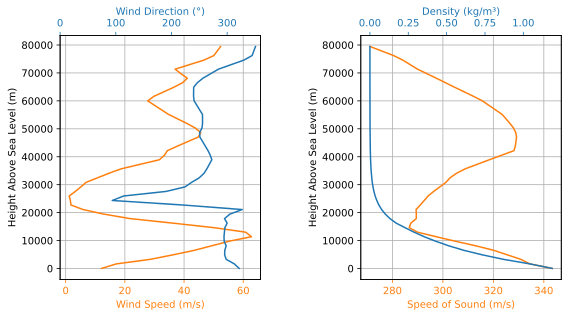

In [10]:
Env.info()

### Creating a Motor

A solid rocket motor is used in this case. To create a motor, the SolidMotor class is used and the required arguments are given.

The SolidMotor class requires the user to have a thrust curve ready. This can come either from a .eng file for a commercial motor, such as below, or a .csv file from a static test measurement.

Besides the thrust curve, other parameters such as grain properties and nozzle dimensions must also be given.

In [10]:
L1520T = SolidMotor(
    thrustSource="/content/drive/Shareddrives/HPRC 2022-23 NASA SL/Senior Design/FRR/Rocket Py/AeroTech_L1520T.eng",
    burnOut=2.4,
    grainNumber=3,
    grainSeparation= 0.0016,
    grainDensity= 1625,
    grainOuterRadius= 0.031661,
    grainInitialInnerRadius= 0.011112,
    grainInitialHeight= 0.1318,
    nozzleRadius= 0.023813,
    throatRadius= 0.0086995,
    interpolationMethod="linear",
)

To see what our thrust curve looks like, along with other import properties, we invoke the info method yet again. You may try the allInfo method if you want more information all at once!


Motor Details
Total Burning Time: 2.6 s
Total Propellant Mass: 1.774 kg
Propellant Exhaust Velocity: 2124.347 m/s
Average Thrust: 1449.614 N
Maximum Thrust: 1696.632 N at 1.1 s after ignition.
Total Impulse: 3768.996 Ns

Plots


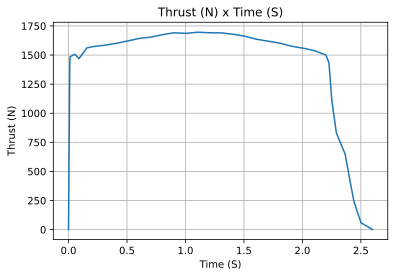

In [11]:
L1520T.info()

### Creating a Rocket

A rocket is composed of several components. Namely, we must have a motor (good thing we have the Pro75M1670 ready), a couple of aerodynamic surfaces (nose cone, fins and tail) and parachutes (if we are not launching a missile).

Let's start by initializing our rocket, named Calisto, supplying it with the Pro75M1670 engine, entering its inertia properties, some dimensions and also its drag curves.

In [12]:
FullScale = Rocket(
    motor=L1520T,
    radius=0.07835,
    mass= (42.5/2.205)-L1520T.propellantInitialMass,
    inertiaI=10.185,
    inertiaZ=0.0528,
    distanceRocketNozzle=-1.375,
    distanceRocketPropellant=-0.89,
    powerOffDrag="/content/drive/Shareddrives/HPRC 2022-23 NASA SL/Senior Design/FRR/Rocket Py/OR_power_off_validated.csv", 
    powerOnDrag="/content/drive/Shareddrives/HPRC 2022-23 NASA SL/Senior Design/FRR/Rocket Py/OR_power_off_validated.csv",
)

FullScale.setRailButtons([-0.275, -1.185]) 

NoseCone = FullScale.addNose(length=.76, kind="ogive", distanceToCM=0.8)

FinSet = FullScale.addTrapezoidalFins(
    n=4,
    rootChord=0.26,
    tipChord=0.1,
    span=0.15,
    distanceToCM=-0.955,
    cantAngle=0,
    radius=None,
    airfoil=None,
)

Tail = FullScale.addTail(
    topRadius=0.0787, bottomRadius=0.0508, length=0.155, distanceToCM=-1.22
)

def drogueTrigger(p, y):
    # p = pressure
    # y = [x, y, z, vx, vy, vz, e0, e1, e2, e3, w1, w2, w3]
    # activate drogue when vz < 0 m/s.
    return True if y[5] < 0 else False


def mainTrigger(p, y):
    # p = pressure
    # y = [x, y, z, vx, vy, vz, e0, e1, e2, e3, w1, w2, w3]
    # activate main when vz < 0 m/s and z < 800 + 1400 m (+1400 due to surface elevation).
    return True if y[5] < 0 and y[2] < 150 + Env.elevation else False


Main = FullScale.addParachute(
    "Main",
    CdS=15.55,
    trigger=mainTrigger,
    samplingRate=105,
    lag=1.5,
    noise=(0, 8.3, 0.5),
)

Drogue = FullScale.addParachute(
    "Drogue",
    CdS= 0.4,
    trigger=drogueTrigger,
    samplingRate=105,
    lag=1.5,
    noise=(0, 8.3, 0.5),
)

#### Adding Aerodynamic Surfaces

Now we define the aerodynamic surfaces. They are really straight forward.

#### Adding Parachutes

Finally, we have parachutes! Calisto will have two parachutes, Drogue and Main.

Both parachutes are activated by some special algorithm, which is usually really complex and a trade secret. Most algorithms are based on pressure sampling only, while some also use acceleration info.

RocketPy allows you to define a trigger function which will decide when to activate the ejection event for each parachute. This trigger function is supplied with pressure measurement at a predefined sampling rate. This pressure signal is usually noisy, so artificial noise parameters can be given. Call help(Rocket.addParachute) for more details. Furthermore, the trigger function also receives the complete state vector of the rocket, allowing us to use velocity, acceleration or even attitude to decide when the parachute event should be triggered.

Here, we define our trigger functions rather simply using Python. However, you can call the exact code which will fly inside your rocket as well.

Just be careful if you run this last cell multiple times! If you do so, your rocket will end up with lots of parachutes which activate together, which may cause problems during the flight simulation. We advise you to re-run all cells which define our rocket before running this, preventing unwanted old parachutes. Alternatively, you can run the following lines to remove parachutes.

```python
Calisto.parachutes.remove(Drogue)
Calisto.parachutes.remove(Main)
```

## Simulating a Flight

Simulating a flight trajectory is as simple as initializing a Flight class object givin the rocket and environnement set up above as inputs. The launch rail inclination and heading are also given here.

In [13]:

TestFlight = Flight(rocket=FullScale, environment=EnvWUAS, inclination=90, heading=0)

## Analyzing the Results

RocketPy gives you many plots, thats for sure! They are divided into sections to keep them organized. Alternatively, see the Flight class documentation to see how to get plots for specific variables only, instead of all of them at once.

Initial Conditions

Position - x: 0.00 m | y: 0.00 m | z: 11.00 m
Velocity - Vx: 0.00 m/s | Vy: 0.00 m/s | Vz: 0.00 m/s
Attitude - e0: 1.000 | e1: 0.000 | e2: 0.000 | e3: 0.000
Euler Angles - Spin φ : 180.00° | Nutation θ: -0.00° | Precession ψ: -180.00°
Angular Velocity - ω1: 0.00 rad/s | ω2: 0.00 rad/s| ω3: 0.00 rad/s


Launch Rail Orientation

Launch Rail Inclination: 90.00°
Launch Rail Heading: 0.00°


Surface Wind Conditions

Frontal Surface Wind Speed: -2.53 m/s
Lateral Surface Wind Speed: -0.45 m/s


 Rail Departure State

Rail Departure Time: 0.279 s
Rail Departure Velocity: 19.113 m/s
Rail Departure Static Margin: 3.067 c
Rail Departure Angle of Attack: 7.766°
Rail Departure Thrust-Weight Ratio: 8.446
Rail Departure Reynolds Number: 3.023e+00


BurnOut State

BurnOut time: 2.600 s
Altitude at burnOut: 249.594 m (AGL)
Rocket velocity at burnOut: 170.133 m/s
Freestream velocity at burnOut: 170.483 m/s
Mach Number at burnOut: 0.509
Kinetic energy at burnOut: 2.533e+05 J


Apogee


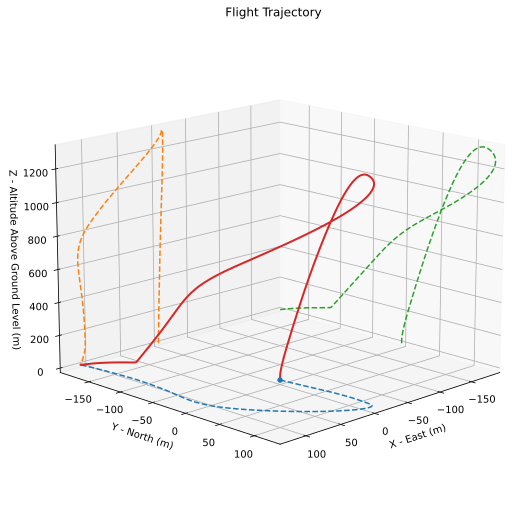



Trajectory Kinematic Plots



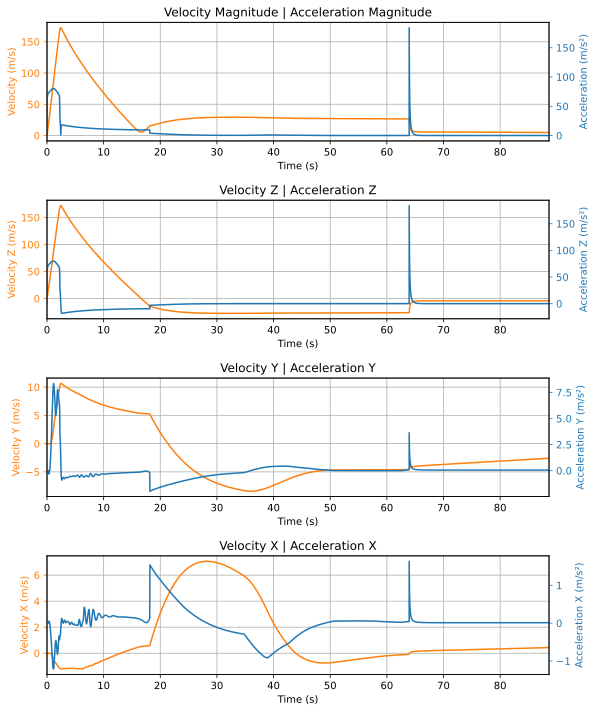



Angular Position Plots



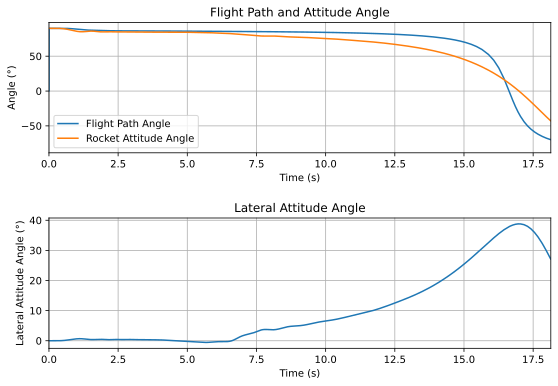



Path, Attitude and Lateral Attitude Angle plots



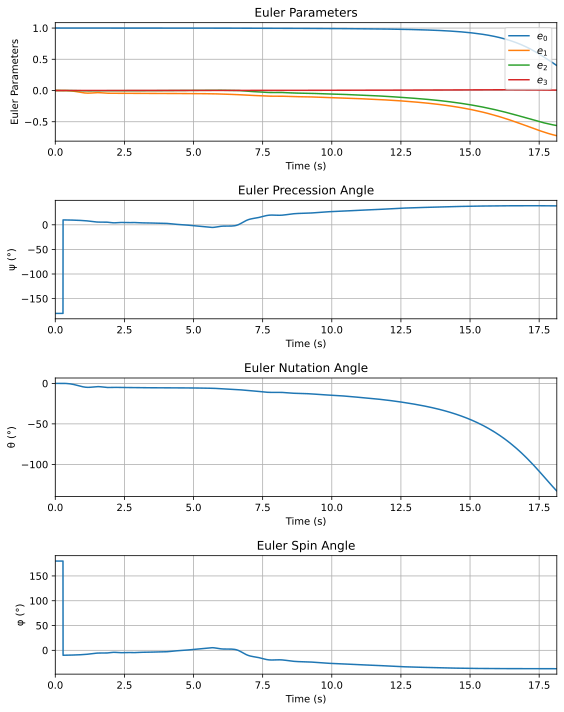



Trajectory Angular Velocity and Acceleration Plots



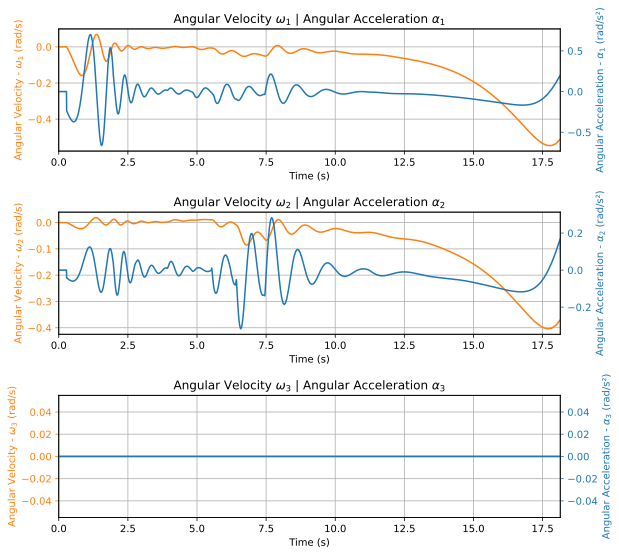



Trajectory Force Plots



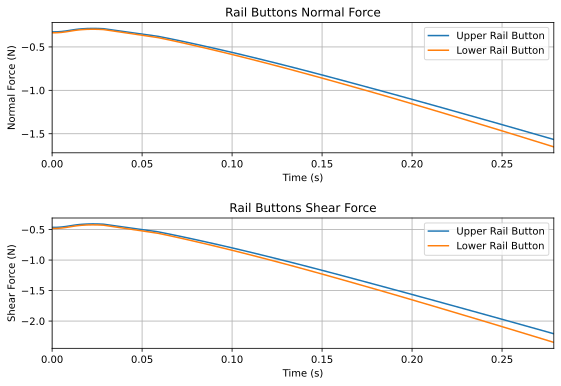

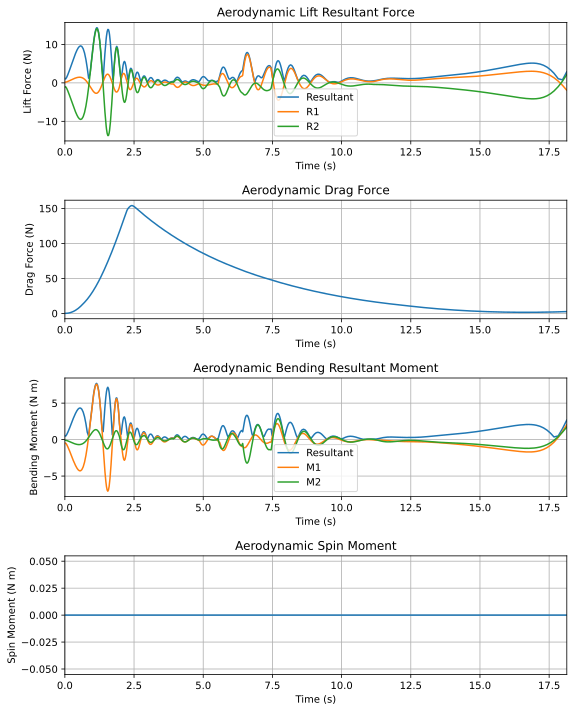



Trajectory Energy Plots



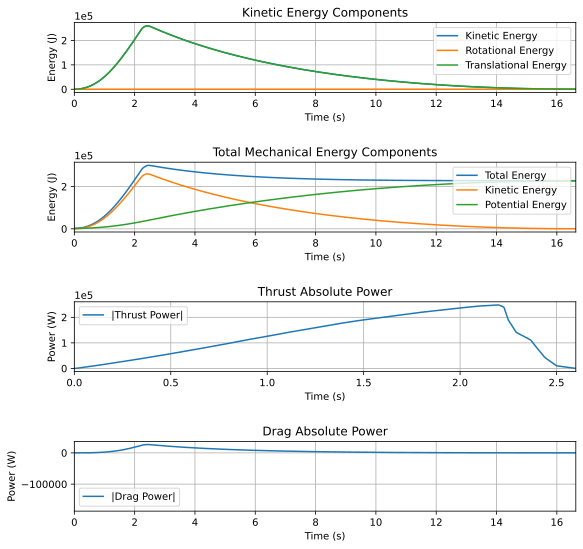



Trajectory Fluid Mechanics Plots



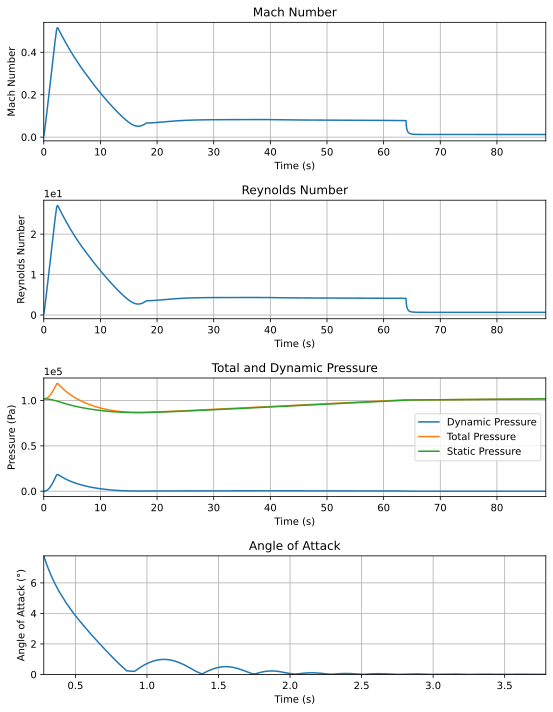



Trajectory Stability and Control Plots



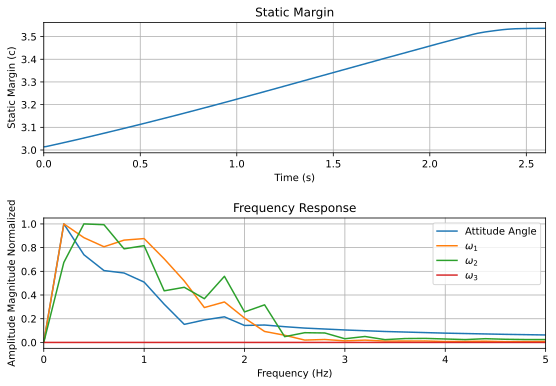

In [14]:
TestFlight.allInfo()


In [15]:

TestFlight.exportData('RocketPy_2.csv','x','y','z','speed','MachNumber','pressure','aerodynamicDrag','acceleration')
import os
os.getcwd()

'/content/RocketPy/docs/notebooks'

Export Flight Trajectory to a .kml file so it can be opened on Google Earth

In [17]:
TestFlight.exportKML(
    fileName="trajectory.kml",
    extrude=True,
    altitudeMode="relativetoground",
)
from google.colab import files
files.download('trajectory.kml')

File  trajectory.kml  saved with success!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Using Simulation for Design

Here, we go through a couple of examples which make use of RocketPy in cool ways to help us design our rocket.

### Dynamic Stability Analysis

Ever wondered how static stability translates into dynamic stability? Different static margins result in different dynamic behavior, which also depends on the rocket's rotational inertial.

Let's make use of RocketPy's helper class called Function to explore how the dynamic stability of Calisto varies if we change the fins span by a certain factor.

Simulating Rocket with Static Margin of 1.924->2.380 c
Simulation Completed at Time: 1.6043 s
Simulating Rocket with Static Margin of 2.168->2.625 c
Simulation Completed at Time: 1.5776 s
Simulating Rocket with Static Margin of 2.413->2.869 c
Simulation Completed at Time: 1.5544 s
Simulating Rocket with Static Margin of 2.657->3.113 c
Simulation Completed at Time: 1.5343 s
Simulating Rocket with Static Margin of 2.901->3.357 c
Simulation Completed at Time: 1.5166 s
Simulating Rocket with Static Margin of 3.145->3.601 c
Simulation Completed at Time: 1.5010 s
Simulating Rocket with Static Margin of 3.389->3.845 c
Simulation Completed at Time: 1.4870 s
[(Function from R1 to R1 : (Time (s)) → (Attitude Angle (°)), '1.92 c | 1.98 c | 2.23 c'), (Function from R1 to R1 : (Time (s)) → (Attitude Angle (°)), '2.17 c | 2.22 c | 2.47 c'), (Function from R1 to R1 : (Time (s)) → (Attitude Angle (°)), '2.41 c | 2.47 c | 2.71 c'), (Function from R1 to R1 : (Time (s)) → (Attitude Angle (°)), '2.66 c | 

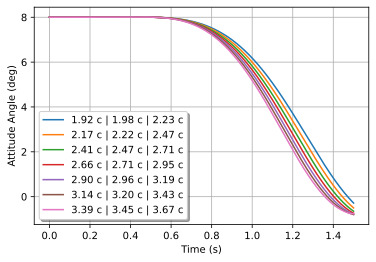

In [18]:
# Helper class
from rocketpy import Function

# Prepare Rocket Class
FullScale_Fin = Rocket(
    motor=L1520T,
    radius=156.7 / 2000,
    mass= 19.5,
    inertiaI=6.60,
    inertiaZ=0.0351,
    distanceRocketNozzle=-1.255,
    distanceRocketPropellant=-0.85704,
    powerOffDrag="../../data/calisto/powerOffDragCurve.csv", #Help figuring out how to remake these
    powerOnDrag="../../data/calisto/powerOnDragCurve.csv",
)
FullScale_Fin.setRailButtons([0.2, -0.5])
Nose = FullScale_Fin.addNose(length=0.55829, kind="ogive", distanceToCM=0.71971)
FinSet = FullScale_Fin.addTrapezoidalFins(
    4, span=0.1, rootChord=0.120, tipChord=0.040, distanceToCM=-1.04956
)
Tail = FullScale_Fin.addTail(
    topRadius=0.0635, bottomRadius=0.0435, length=0.060, distanceToCM=-1.194656
)

# Prepare Environment Class
Env = Environment(5.2, 9.8)
Env.setAtmosphericModel(type="CustomAtmosphere", wind_v= 5)

# Simulate Different Static Margins by Varying Fin Position
simulation_results = []

for factor in [1.2, 1.25, 1.3, 1.35, 1.4, 1.45, 1.5]:
    # Modify rocket fin set by removing previous one and adding new one
    FullScale_Fin.aerodynamicSurfaces.remove(FinSet)
    FinSet = FullScale_Fin.addTrapezoidalFins(
    4, span=0.100, rootChord=0.120, tipChord=0.040, distanceToCM=-1.04956*factor
  )
    # Simulate
    print(
        "Simulating Rocket with Static Margin of {:1.3f}->{:1.3f} c".format(
            FullScale_Fin.staticMargin(0), FullScale_Fin.staticMargin(FullScale_Fin.motor.burnOutTime)
        )
    )
    TestFlight = Flight(
        rocket=FullScale_Fin,
        environment=Env,
        inclination=8,
        heading=0,
        maxTimeStep=0.1,
        maxTime=5,
        terminateOnApogee=True,
        verbose=True,
    )
    # Post process flight data
    TestFlight.postProcess()
    # Store Results
    staticMarginAtIgnition = FullScale_Fin.staticMargin(0)
    staticMarginAtOutOfRail = FullScale_Fin.staticMargin(TestFlight.outOfRailTime)
    staticMarginAtSteadyState = FullScale_Fin.staticMargin(TestFlight.tFinal)
    simulation_results += [
        (
            TestFlight.attitudeAngle,
            "{:1.2f} c | {:1.2f} c | {:1.2f} c".format(
                staticMarginAtIgnition,
                staticMarginAtOutOfRail,
                staticMarginAtSteadyState,
            ),
        )
    ]
print(simulation_results)
Function.comparePlots(
    simulation_results,
    lower=0,
    upper=1.5,
    xlabel="Time (s)",
    ylabel="Attitude Angle (deg)",
)

In [19]:
print(simulation_results)

[(Function from R1 to R1 : (Time (s)) → (Attitude Angle (°)), '1.92 c | 1.98 c | 2.23 c'), (Function from R1 to R1 : (Time (s)) → (Attitude Angle (°)), '2.17 c | 2.22 c | 2.47 c'), (Function from R1 to R1 : (Time (s)) → (Attitude Angle (°)), '2.41 c | 2.47 c | 2.71 c'), (Function from R1 to R1 : (Time (s)) → (Attitude Angle (°)), '2.66 c | 2.71 c | 2.95 c'), (Function from R1 to R1 : (Time (s)) → (Attitude Angle (°)), '2.90 c | 2.96 c | 3.19 c'), (Function from R1 to R1 : (Time (s)) → (Attitude Angle (°)), '3.14 c | 3.20 c | 3.43 c'), (Function from R1 to R1 : (Time (s)) → (Attitude Angle (°)), '3.39 c | 3.45 c | 3.67 c')]


### Characteristic Frequency Calculation

Here we analyse the characteristic frequency of oscillation of our rocket just as it leaves the launch rail. Note that when we ran TestFlight.allInfo(), one of the plots already showed us the frequency spectrum of our flight. Here, however, we have more control of what we are plotting.

In [20]:
import numpy as np
import matplotlib.pyplot as plt

#Env = Environment(
#    railLength=5.2, latitude=32.990254, longitude=-106.974998, elevation=1400
#)

Env.setAtmosphericModel(type="CustomAtmosphere", wind_v=-5)

# Prepare Motor
#Pro75M1670 = SolidMotor(
#    thrustSource="../../data/motors/Cesaroni_M1670.eng",
#    burnOut=3.9,
#    grainNumber=5,
#    grainSeparation=5 / 1000,
#    grainDensity=1815,
#    grainOuterRadius=33 / 1000,
#    grainInitialInnerRadius=15 / 1000,
#    grainInitialHeight=120 / 1000,
#    nozzleRadius=33 / 1000,
#    throatRadius=11 / 1000,
#    interpolationMethod="linear",
#)

# Prepare Rocket
#Calisto = Rocket(
#    motor=Pro75M1670,
#    radius=127 / 2000,
#    mass=19.197 - 2.956,
#    inertiaI=6.60,
#    inertiaZ=0.0351,
#    distanceRocketNozzle=-1.255,
#    distanceRocketPropellant=-0.85704,
#    powerOffDrag="../../data/calisto/powerOffDragCurve.csv",
#    powerOnDrag="../../data/calisto/powerOnDragCurve.csv",
#)

#Calisto.setRailButtons([0.2, -0.5])

#Nose = Calisto.addNose(length=0.55829, kind="vonKarman", distanceToCM=0.71971)
#FinSet = Calisto.addTrapezoidalFins(
#    4, span=0.100, rootChord=0.120, tipChord=0.040, distanceToCM=-1.04956
#)
#Tail = Calisto.addTail(
#    topRadius=0.0635, bottomRadius=0.0435, length=0.060, distanceToCM=-1.194656
#)

simulation_results_rails = []

for factor2 in [ .1, .5, 1, 1.5, 2]:

    # Modify rocket rail by removing previous one and adding new one
    button1 = factor2*.2
    button2 = factor2*-0.5 - factor2*.1
    FullScale.setRailButtons([button1, button2])
    print(FullScale.railButtons.distanceToCM)
    
    # Simulate first 5 seconds of Flight
    TestFlight = Flight(
        rocket=FullScale,
        environment=Env,
        inclination=85,
        heading=0,
        maxTimeStep=0.01,
        maxTime=5,
)
    TestFlight.postProcess()

    # Perform a Fourier Analysis
    Fs = 100.0
    # sampling rate
    Ts = 1.0 / Fs
    # sampling interval
    t = np.arange(1, 400, Ts)  # time vector
    ff = 5
    # frequency of the signal
    y = TestFlight.attitudeAngle(t) - np.mean(TestFlight.attitudeAngle(t))
    n = len(y)  # length of the signal
    k = np.arange(n)
    T = n / Fs
    frq = k / T  # two sides frequency range
    frq = frq[range(n // 2)]  # one side frequency range
    Y = np.fft.fft(y) / n  # fft computing and normalization
    Y = abs(Y[range(n // 2)])

    simulation_results_rails += [t,y,frq,Y]

print(simulation_results_rails)


[0.020000000000000004, -0.060000000000000005]
[0.1, -0.3]
[0.2, -0.6]
[0.30000000000000004, -0.9]
[0.4, -1.2]
[array([  1.  ,   1.01,   1.02, ..., 399.97, 399.98, 399.99]), array([ 2.96186245,  2.8289671 ,  2.70160096, ..., -0.01752847,
       -0.01752847, -0.01752847]), array([0.00000000e+00, 2.50626566e-03, 5.01253133e-03, ...,
       4.99924812e+01, 4.99949875e+01, 4.99974937e+01]), array([8.31281577e-16, 1.75265301e-02, 1.75207167e-02, ...,
       3.81132035e-05, 3.81124817e-05, 3.81120474e-05]), array([  1.  ,   1.01,   1.02, ..., 399.97, 399.98, 399.99]), array([ 2.95676056,  2.82435696,  2.69750829, ..., -0.01756243,
       -0.01756243, -0.01756243]), array([0.00000000e+00, 2.50626566e-03, 5.01253133e-03, ...,
       4.99924812e+01, 4.99949875e+01, 4.99974937e+01]), array([3.77602711e-15, 1.75604863e-02, 1.75546617e-02, ...,
       3.80464222e-05, 3.80456989e-05, 3.80452637e-05]), array([  1.  ,   1.01,   1.02, ..., 399.97, 399.98, 399.99]), array([ 2.95055749,  2.81876672,  2.6

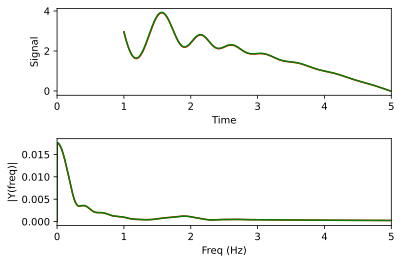

In [21]:

fig, ax = plt.subplots(2, 1)
ax[0].plot(simulation_results_rails[0], simulation_results_rails[1],"r", simulation_results_rails[12], simulation_results_rails[13],"g")
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Signal")
ax[0].set_xlim((0, 5))
ax[1].plot(simulation_results_rails[2], simulation_results_rails[3],"r", simulation_results_rails[14], simulation_results_rails[15],"g")  # plotting the spectrum
ax[1].set_xlabel("Freq (Hz)")
ax[1].set_ylabel("|Y(freq)|")
ax[1].set_xlim((0, 5))
plt.subplots_adjust(hspace=0.5)
plt.show()

### Apogee as a Function of Mass

This one is a classic one! We always need to know how much our rocket's apogee will change when our payload gets heavier.

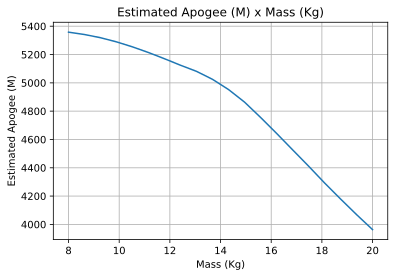

In [22]:
def apogee(mass):
    # Prepare Environment
    Env = Environment(
        railLength=5.2,
        latitude=32.990254,
        longitude=-106.974998,
        elevation=1400,
        date=(2018, 6, 20, 18),
    )

    Env.setAtmosphericModel(type="CustomAtmosphere", wind_v=-5)

    # Prepare Motor
    Pro75M1670 = SolidMotor(
        thrustSource="../../data/motors/Cesaroni_M1670.eng",
        burnOut=3.9,
        grainNumber=5,
        grainSeparation=5 / 1000,
        grainDensity=1815,
        grainOuterRadius=33 / 1000,
        grainInitialInnerRadius=15 / 1000,
        grainInitialHeight=120 / 1000,
        nozzleRadius=33 / 1000,
        throatRadius=11 / 1000,
        interpolationMethod="linear",
    )

    # Prepare Rocket
    Calisto = Rocket(
        motor=Pro75M1670,
        radius=127 / 2000,
        mass=mass,
        inertiaI=6.60,
        inertiaZ=0.0351,
        distanceRocketNozzle=-1.255,
        distanceRocketPropellant=-0.85704,
        powerOffDrag="../../data/calisto/powerOffDragCurve.csv",
        powerOnDrag="../../data/calisto/powerOnDragCurve.csv",
    )

    Calisto.setRailButtons([0.2, -0.5])
    Nose = Calisto.addNose(length=0.55829, kind="vonKarman", distanceToCM=0.71971)
    FinSet = Calisto.addTrapezoidalFins(
        4, span=0.100, rootChord=0.120, tipChord=0.040, distanceToCM=-1.04956
    )
    Tail = Calisto.addTail(
        topRadius=0.0635, bottomRadius=0.0435, length=0.060, distanceToCM=-1.194656
    )

    # Simulate Flight until Apogee
    TestFlight = Flight(
        rocket=Calisto,
        environment=Env,
        inclination=85,
        heading=0,
        terminateOnApogee=True,
    )
    return TestFlight.apogee


apogeebymass = Function(apogee, inputs="Mass (kg)", outputs="Estimated Apogee (m)")
apogeebymass.plot(8, 20, 20)

### Out of Rail Speed as a Function of Mass

To finish off, lets make a really important plot. Out of rail speed is the speed our rocket has when it is leaving the launch rail. This is crucial to make sure it can fly safely after leaving the rail. A common rule of thumb is that our rocket's out of rail speed should be 4 times the wind speed so that it does not stall and become unstable.

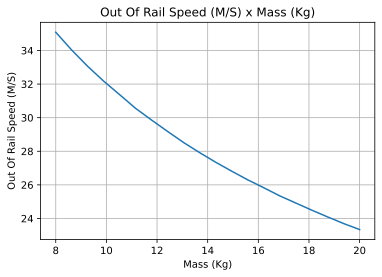

In [23]:
def speed(mass):
    # Prepare Environment
    Env = Environment(
        railLength=5.2,
        latitude=32.990254,
        longitude=-106.974998,
        elevation=1400,
        date=(2018, 6, 20, 18),
    )

    Env.setAtmosphericModel(type="CustomAtmosphere", wind_v=-5)

    # Prepare Motor
    Pro75M1670 = SolidMotor(
        thrustSource="../../data/motors/Cesaroni_M1670.eng",
        burnOut=3.9,
        grainNumber=5,
        grainSeparation=5 / 1000,
        grainDensity=1815,
        grainOuterRadius=33 / 1000,
        grainInitialInnerRadius=15 / 1000,
        grainInitialHeight=120 / 1000,
        nozzleRadius=33 / 1000,
        throatRadius=11 / 1000,
        interpolationMethod="linear",
    )

    # Prepare Rocket
    Calisto = Rocket(
        motor=Pro75M1670,
        radius=127 / 2000,
        mass=mass,
        inertiaI=6.60,
        inertiaZ=0.0351,
        distanceRocketNozzle=-1.255,
        distanceRocketPropellant=-0.85704,
        powerOffDrag="../../data/calisto/powerOffDragCurve.csv",
        powerOnDrag="../../data/calisto/powerOnDragCurve.csv",
    )

    Calisto.setRailButtons([0.2, -0.5])
    Nose = Calisto.addNose(length=0.55829, kind="vonKarman", distanceToCM=0.71971)
    FinSet = Calisto.addTrapezoidalFins(
        4, span=0.100, rootChord=0.120, tipChord=0.040, distanceToCM=-1.04956
    )
    Tail = Calisto.addTail(
        topRadius=0.0635, bottomRadius=0.0435, length=0.060, distanceToCM=-1.194656
    )

    # Simulate Flight until Apogee
    TestFlight = Flight(
        rocket=Calisto,
        environment=Env,
        inclination=85,
        heading=0,
        terminateOnApogee=True,
    )
    return TestFlight.outOfRailVelocity


speedbymass = Function(speed, inputs="Mass (kg)", outputs="Out of Rail Speed (m/s)")
speedbymass.plot(8, 20, 20)

In [24]:
analysis_parameters = {
    # Mass Details
    "rocketMass": (
        8.257,
        0.001,
    ),  # Rocket's dry mass (kg) and its uncertainty (standard deviation)
    # Propulsion Details - run help(SolidMotor) for more information
    "impulse": (1415.15, 35.3),  # Motor total impulse (N*s)
    "burnOut": (5.274, 1),  # Motor burn out time (s)
    "nozzleRadius": (21.642 / 1000, 0.5 / 1000),  # Motor's nozzle radius (m)
    "throatRadius": (8 / 1000, 0.5 / 1000),  # Motor's nozzle throat radius (m)
    "grainSeparation": (
        6 / 1000,
        1 / 1000,
    ),  # Motor's grain separation (axial distance between two grains) (m)
    "grainDensity": (1707, 50),  # Motor's grain density (kg/m^3)
    "grainOuterRadius": (21.4 / 1000, 0.375 / 1000),  # Motor's grain outer radius (m)
    "grainInitialInnerRadius": (
        9.65 / 1000,
        0.375 / 1000,
    ),  # Motor's grain inner radius (m)
    "grainInitialHeight": (120 / 1000, 1 / 1000),  # Motor's grain height (m)
    # Aerodynamic Details - run help(Rocket) for more information
    "inertiaI": (
        3.675,
        0.03675,
    ),  # Rocket's inertia moment perpendicular to its axis (kg*m^2)
    "inertiaZ": (
        0.007,
        0.00007,
    ),  # Rocket's inertia moment relative to its axis (kg*m^2)
    "radius": (40.45 / 1000, 0.001),  # Rocket's radius (kg*m^2)
    "distanceRocketNozzle": (
        -1.024,
        0.001,
    ),  # Distance between rocket's center of dry mass and nozzle exit plane (m) (negative)
    "distanceRocketPropellant": (
        -0.571,
        0.001,
    ),  # Distance between rocket's center of dry mass and and center of propellant mass (m) (negative)
    "powerOffDrag": (
        0.9081 / 1.05,
        0.033,
    ),  # Multiplier for rocket's drag curve. Usually has a mean value of 1 and a uncertainty of 5% to 10%
    "powerOnDrag": (
        0.9081 / 1.05,
        0.033,
    ),  # Multiplier for rocket's drag curve. Usually has a mean value of 1 and a uncertainty of 5% to 10%
    "noseLength": (0.274, 0.001),  # Rocket's nose cone length (m)
    "noseDistanceToCM": (
        1.134,
        0.001,
    ),  # Axial distance between rocket's center of dry mass and nearest point in its nose cone (m)
    "finSpan": (0.077, 0.0005),  # Fin span (m)
    "finRootChord": (0.058, 0.0005),  # Fin root chord (m)
    "finTipChord": (0.018, 0.0005),  # Fin tip chord (m)
    "finDistanceToCM": (
        -0.906,
        0.001,
    ),  # Axial distance between rocket's center of dry mass and nearest point in its fin (m)
    # Launch and Environment Details - run help(Environment) and help(Flight) for more information
    "inclination": (
        84.7,
        1,
    ),  # Launch rail inclination angle relative to the horizontal plane (degrees)
    "heading": (53, 2),  # Launch rail heading relative to north (degrees)
    "railLength": (5.7, 0.0005),  # Launch rail length (m)
    "ensembleMember": list(range(10)),  # Members of the ensemble forecast to be used
    # Parachute Details - run help(Rocket) for more information
    "CdSDrogue": (
        0.349 * 1.3,
        0.07,
    ),  # Drag coefficient times reference area for the drogue chute (m^2)
    "lag_rec": (
        1,
        0.5,
    ),  # Time delay between parachute ejection signal is detected and parachute is inflated (s)
    # Electronic Systems Details - run help(Rocket) for more information
    "lag_se": (
        0.73,
        0.16,
    ),  # Time delay between sensor signal is received and ejection signal is fired (s)
}

In [25]:
def flight_settings(analysis_parameters, total_number):
    i = 0
    while i < total_number:
        # Generate a flight setting
        flight_setting = {}
        for parameter_key, parameter_value in analysis_parameters.items():
            if type(parameter_value) is tuple:
                flight_setting[parameter_key] = normal(*parameter_value)
            else:
                flight_setting[parameter_key] = choice(parameter_value)

        # Skip if certain values are negative, which happens due to the normal curve but isnt realistic
        if flight_setting["lag_rec"] < 0 or flight_setting["lag_se"] < 0:
            continue

        # Update counter
        i += 1
        # Yield a flight setting
        yield flight_setting

In [26]:
def export_flight_data(flight_setting, flight_data, exec_time):
    # Generate flight results
    flight_result = {
        "outOfRailTime": flight_data.outOfRailTime,
        "outOfRailVelocity": flight_data.outOfRailVelocity,
        "apogeeTime": flight_data.apogeeTime,
        "apogeeAltitude": flight_data.apogee - Env.elevation,
        "apogeeX": flight_data.apogeeX,
        "apogeeY": flight_data.apogeeY,
        "impactTime": flight_data.tFinal,
        "impactX": flight_data.xImpact,
        "impactY": flight_data.yImpact,
        "impactVelocity": flight_data.impactVelocity,
        "initialStaticMargin": flight_data.rocket.staticMargin(0),
        "outOfRailStaticMargin": flight_data.rocket.staticMargin(
            TestFlight.outOfRailTime
        ),
        "finalStaticMargin": flight_data.rocket.staticMargin(
            TestFlight.rocket.motor.burnOutTime
        ),
        "numberOfEvents": len(flight_data.parachuteEvents),
        "executionTime": exec_time,
    }

    # Calculate maximum reached velocity
    sol = np.array(flight_data.solution)
    flight_data.vx = Function(
        sol[:, [0, 4]], "Time (s)", "Vx (m/s)", "linear", extrapolation="natural"
    )
    flight_data.vy = Function(
        sol[:, [0, 5]], "Time (s)", "Vy (m/s)", "linear", extrapolation="natural"
    )
    flight_data.vz = Function(
        sol[:, [0, 6]], "Time (s)", "Vz (m/s)", "linear", extrapolation="natural"
    )
    flight_data.v = (
        flight_data.vx**2 + flight_data.vy**2 + flight_data.vz**2
    ) ** 0.5
    flight_data.maxVel = np.amax(flight_data.v.source[:, 1])
    flight_result["maxVelocity"] = flight_data.maxVel

    # Take care of parachute results
    if len(flight_data.parachuteEvents) > 0:
        flight_result["drogueTriggerTime"] = flight_data.parachuteEvents[0][0]
        flight_result["drogueInflatedTime"] = (
            flight_data.parachuteEvents[0][0] + flight_data.parachuteEvents[0][1].lag
        )
        flight_result["drogueInflatedVelocity"] = flight_data.v(
            flight_data.parachuteEvents[0][0] + flight_data.parachuteEvents[0][1].lag
        )
    else:
        flight_result["drogueTriggerTime"] = 0
        flight_result["drogueInflatedTime"] = 0
        flight_result["drogueInflatedVelocity"] = 0

    # Write flight setting and results to file
    dispersion_input_file.write(str(flight_setting) + "\n")
    dispersion_output_file.write(str(flight_result) + "\n")


def export_flight_error(flight_setting):
    dispersion_error_file.write(str(flight_setting) + "\n")

In [27]:
from datetime import datetime
from time import process_time, perf_counter, time
import glob

from rocketpy import Environment, SolidMotor, Rocket, Flight, Function

import numpy as np
from numpy.random import normal, uniform, choice
from IPython.display import display

%config InlineBackend.figure_formats = ['svg']
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
mpl.rcParams["figure.figsize"] = [8, 5]
mpl.rcParams["figure.dpi"] = 120
mpl.rcParams["font.size"] = 14
mpl.rcParams["legend.fontsize"] = 14
mpl.rcParams["figure.titlesize"] = 14

# Basic analysis info
filename = "/fullscale_rocket_v0"
number_of_simulations = 1000


# Create data files for inputs, outputs and error logging
dispersion_error_file = open(str(filename) + ".disp_errors.txt", "w")
dispersion_input_file = open(str(filename) + ".disp_inputs.txt", "w")
dispersion_output_file = open(str(filename) + ".disp_outputs.txt", "w")

# Initialize counter and timer
i = 0

initial_wall_time = time()
initial_cpu_time = process_time()

# Define basic Environment object
Env = Environment(
    railLength=3.66, date=(2019, 8, 10, 21), latitude=-23.363611, longitude=-48.011389
)
Env.setElevation(668)
Env.maxExpectedHeight = 1500
Env.setAtmosphericModel(
    type="Ensemble",
    file="/content/RocketPy/data/weather/LASC2019_TATUI_reanalysis_ensemble.nc",
    dictionary="ECMWF",
)


# Iterate over flight settings
out = display("Starting", display_id=True)
for setting in flight_settings(analysis_parameters, number_of_simulations):
    start_time = process_time()
    i += 1

    # Update environment object
    Env.selectEnsembleMember(setting["ensembleMember"])
    Env.railLength = setting["railLength"]

    L1520T = SolidMotor(
    thrustSource="/content/drive/Shareddrives/HPRC 2022-23 NASA SL/Senior Design/FRR/Rocket Py/AeroTech_L1520T.eng",
    burnOut=2.4,
    grainNumber=3,
    grainSeparation= 0.0016,
    grainDensity= 1625,
    grainOuterRadius= 0.031661,
    grainInitialInnerRadius= 0.011112,
    grainInitialHeight= 0.1318,
    nozzleRadius= 0.023813,
    throatRadius= 0.0086995,
    interpolationMethod="linear",
)

    # Create rocket
    FullScale = Rocket(
    motor=L1520T,
    radius=156.7 / 2000,
    mass= 18.2,
    inertiaI=6.60,
    inertiaZ=0.0351,
    distanceRocketNozzle=-1.255,
    distanceRocketPropellant=-0.85704,
    powerOffDrag="../../data/calisto/powerOffDragCurve.csv", #Help figuring out how to remake these
    powerOnDrag="../../data/calisto/powerOnDragCurve.csv",
)

FullScale.setRailButtons([0.2, -0.5]) #Ben Help what does this mean? And how do I simulate it

NoseCone = FullScale.addNose(length=.762, kind="ogive", distanceToCM=0.71971)

FinSet = FullScale.addTrapezoidalFins(
    n=4,
    rootChord=0.120,
    tipChord=0.040,
    span=0.100,
    distanceToCM=-1.04956,
    cantAngle=0,
    radius=None,
    airfoil=None,
)

Tail = FullScale.addTail(
    topRadius=0.0635, bottomRadius=0.0435, length=0.060, distanceToCM=-1.194656
)

def drogueTrigger(p, y):
    # p = pressure
    # y = [x, y, z, vx, vy, vz, e0, e1, e2, e3, w1, w2, w3]
    # activate drogue when vz < 0 m/s.
    return True if y[5] < 0 else False


def mainTrigger(p, y):
    # p = pressure
    # y = [x, y, z, vx, vy, vz, e0, e1, e2, e3, w1, w2, w3]
    # activate main when vz < 0 m/s and z < 800 + 1400 m (+1400 due to surface elevation).
    return True if y[5] < 0 and y[2] < 182 + Env.elevation else False


Main = FullScale.addParachute(
    "Main",
    CdS=10.0,
    trigger=mainTrigger,
    samplingRate=105,
    lag=1.5,
    noise=(0, 8.3, 0.5),
)

Drogue = FullScale.addParachute(
    "Drogue",
    CdS=1.0,
    trigger=drogueTrigger,
    samplingRate=105,
    lag=1.5,
    noise=(0, 8.3, 0.5),
)

# Run trajectory simulation
try:
    TestFlight = Flight(
        rocket=FullScale,
        environment=Env,
        inclination=setting["inclination"],
        heading=setting["heading"],
        maxTime=600,
    )
    export_flight_data(setting, TestFlight, process_time() - start_time)
except Exception as E:
    print(E)
    export_flight_error(setting)

# Register time
out.update(
    f"Curent iteration: {i:06d} | Average Time per Iteration: {(process_time() - initial_cpu_time)/i:2.6f} s"
)

# Done

## Print and save total time
final_string = f"Completed {i} iterations successfully. Total CPU time: {process_time() - initial_cpu_time} s. Total wall time: {time() - initial_wall_time} s"
out.update(final_string)
dispersion_input_file.write(final_string + "\n")
dispersion_output_file.write(final_string + "\n")
dispersion_error_file.write(final_string + "\n")

## Close files
dispersion_input_file.close()
dispersion_output_file.close()
dispersion_error_file.close()

'Completed 1000 iterations successfully. Total CPU time: 35.362620162999995 s. Total wall time: 40.96321678161621 s'

In [28]:
filename = "/fullscale_rocket_v0"

# Initialize variable to store all results
dispersion_general_results = []

dispersion_results = {
    "outOfRailTime": [],
    "outOfRailVelocity": [],
    "apogeeTime": [],
    "apogeeAltitude": [],
    "apogeeX": [],
    "apogeeY": [],
    "impactTime": [],
    "impactX": [],
    "impactY": [],
    "impactVelocity": [],
    "initialStaticMargin": [],
    "outOfRailStaticMargin": [],
    "finalStaticMargin": [],
    "numberOfEvents": [],
    "maxVelocity": [],
    "drogueTriggerTime": [],
    "drogueInflatedTime": [],
    "drogueInflatedVelocity": [],
    "executionTime": [],
}

# Get all dispersion results
# Get file
dispersion_output_file = open(str(filename) + ".disp_outputs.txt", "r+")

# Read each line of the file and convert to dict
for line in dispersion_output_file:
    # Skip comments lines
    if line[0] != "{":
        continue
    # Eval results and store them
    flight_result = eval(line)
    dispersion_general_results.append(flight_result)
    for parameter_key, parameter_value in flight_result.items():
        dispersion_results[parameter_key].append(parameter_value)

# Close data file
dispersion_output_file.close()

# Print number of flights simulated
N = len(dispersion_general_results)
print("Number of simulations: ", N)
print(dispersion_general_results)

Number of simulations:  1
[{'outOfRailTime': 0.2645802672225376, 'outOfRailVelocity': 17.362643754128325, 'apogeeTime': 16.985746278804417, 'apogeeAltitude': 1331.2964601255792, 'apogeeX': 162.0039855130359, 'apogeeY': 188.68456423642832, 'impactTime': 107.73140171646125, 'impactX': 607.0413876277386, 'impactY': -5.377048255273799, 'impactVelocity': -5.71972590658505, 'initialStaticMargin': 0.6660293850534004, 'outOfRailStaticMargin': 0.713088575801239, 'finalStaticMargin': 1.1518357601772995, 'numberOfEvents': 2, 'executionTime': 1.1654495869999977, 'maxVelocity': 167.62936194285098, 'drogueTriggerTime': 16.99047619047619, 'drogueInflatedTime': 18.49047619047619, 'drogueInflatedVelocity': 19.580885146682153}]


Out of Rail Time -         Mean Value: 0.265 s
Out of Rail Time - Standard Deviation: 0.000 s


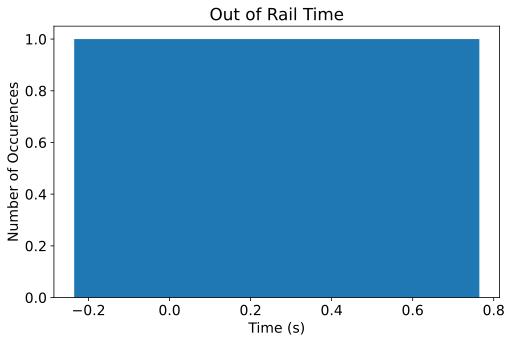

In [29]:
print(
    f'Out of Rail Time -         Mean Value: {np.mean(dispersion_results["outOfRailTime"]):0.3f} s'
)
print(
    f'Out of Rail Time - Standard Deviation: {np.std(dispersion_results["outOfRailTime"]):0.3f} s'
)

plt.figure()
plt.hist(dispersion_results["outOfRailTime"], bins=int(N**0.5))
plt.title("Out of Rail Time")
plt.xlabel("Time (s)")
plt.ylabel("Number of Occurences")
plt.show()

# You can also use Plotly instead of Matplotlib if you wish!
# import plotly.express as px
# fig1 = px.histogram(
#     x=dispersion_results["outOfRailTime"],
#     title='Out of Rail Time',
#     nbins=int(N**0.5)
# )
# fig1.update_layout(
#     xaxis_title_text='Time (s)',
#     yaxis_title_text='Number of occurences'
# )

Out of Rail Velocity -         Mean Value: 17.363 m/s
Out of Rail Velocity - Standard Deviation: 0.000 m/s


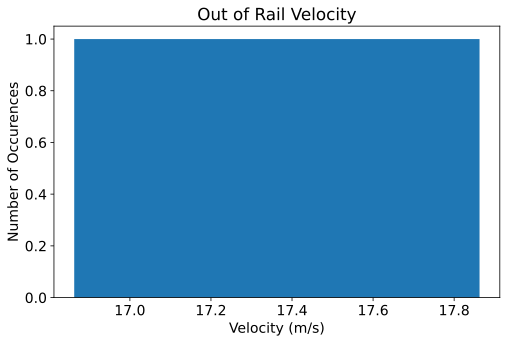

In [30]:
print(
    f'Out of Rail Velocity -         Mean Value: {np.mean(dispersion_results["outOfRailVelocity"]):0.3f} m/s'
)
print(
    f'Out of Rail Velocity - Standard Deviation: {np.std(dispersion_results["outOfRailVelocity"]):0.3f} m/s'
)

plt.figure()
plt.hist(dispersion_results["outOfRailVelocity"], bins=int(N**0.5))
plt.title("Out of Rail Velocity")
plt.xlabel("Velocity (m/s)")
plt.ylabel("Number of Occurences")
plt.show()

Apogee Time -         Mean Value: 16.986 s
Apogee Time - Standard Deviation: 0.000 s


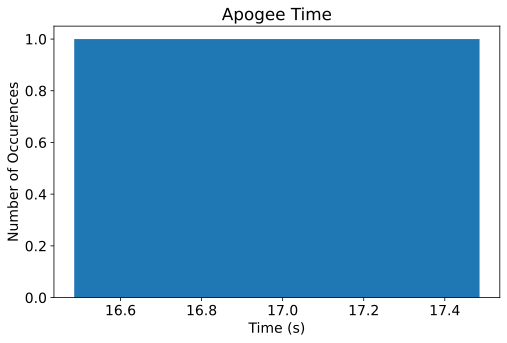

In [31]:
print(
    f'Apogee Time -         Mean Value: {np.mean(dispersion_results["apogeeTime"]):0.3f} s'
)
print(
    f'Apogee Time - Standard Deviation: {np.std(dispersion_results["apogeeTime"]):0.3f} s'
)

plt.figure()
plt.hist(dispersion_results["apogeeTime"], bins=int(N**0.5))
plt.title("Apogee Time")
plt.xlabel("Time (s)")
plt.ylabel("Number of Occurences")
plt.show()

Apogee Altitude -         Mean Value: 1331.296 m
Apogee Altitude - Standard Deviation: 0.000 m


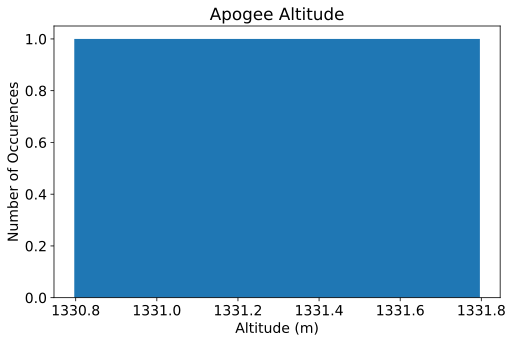

In [32]:
print(
    f'Apogee Altitude -         Mean Value: {np.mean(dispersion_results["apogeeAltitude"]):0.3f} m'
)
print(
    f'Apogee Altitude - Standard Deviation: {np.std(dispersion_results["apogeeAltitude"]):0.3f} m'
)

plt.figure()
plt.hist(dispersion_results["apogeeAltitude"], bins=int(N**0.5))
plt.title("Apogee Altitude")
plt.xlabel("Altitude (m)")
plt.ylabel("Number of Occurences")
plt.show()

# Real measured apogee for Valetudo = 860 m

Initial Static Margin -             Mean Value: 0.666 c
Initial Static Margin -     Standard Deviation: 0.000 c
Out of Rail Static Margin -         Mean Value: 0.713 c
Out of Rail Static Margin - Standard Deviation: 0.000 c
Final Static Margin -               Mean Value: 1.152 c
Final Static Margin -       Standard Deviation: 0.000 c


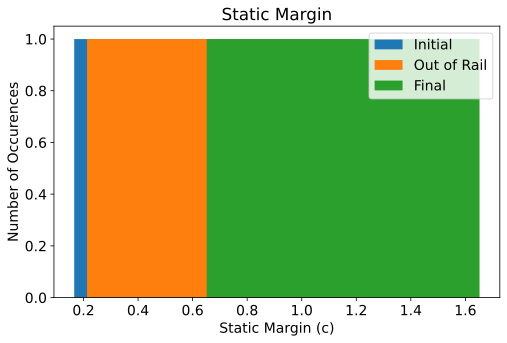

In [33]:
print(
    f'Initial Static Margin -             Mean Value: {np.mean(dispersion_results["initialStaticMargin"]):0.3f} c'
)
print(
    f'Initial Static Margin -     Standard Deviation: {np.std(dispersion_results["initialStaticMargin"]):0.3f} c'
)

print(
    f'Out of Rail Static Margin -         Mean Value: {np.mean(dispersion_results["outOfRailStaticMargin"]):0.3f} c'
)
print(
    f'Out of Rail Static Margin - Standard Deviation: {np.std(dispersion_results["outOfRailStaticMargin"]):0.3f} c'
)

print(
    f'Final Static Margin -               Mean Value: {np.mean(dispersion_results["finalStaticMargin"]):0.3f} c'
)
print(
    f'Final Static Margin -       Standard Deviation: {np.std(dispersion_results["finalStaticMargin"]):0.3f} c'
)

plt.figure()
plt.hist(dispersion_results["initialStaticMargin"], label="Initial", bins=int(N**0.5))
plt.hist(
    dispersion_results["outOfRailStaticMargin"], label="Out of Rail", bins=int(N**0.5)
)
plt.hist(dispersion_results["finalStaticMargin"], label="Final", bins=int(N**0.5))
plt.legend()
plt.title("Static Margin")
plt.xlabel("Static Margin (c)")
plt.ylabel("Number of Occurences")
plt.show()

In [34]:
# Import libraries
from imageio import imread
from matplotlib.patches import Ellipse

# Import background map
img = imread("/content/RocketPy/data/valetudo/valetudo_basemap.png")

# Retrieve dispersion data por apogee and impact XY position
apogeeX = np.array(dispersion_results["apogeeX"])
apogeeY = np.array(dispersion_results["apogeeY"])
impactX = np.array(dispersion_results["impactX"])
impactY = np.array(dispersion_results["impactY"])

# Define function to calculate eigen values
def eigsorted(cov):
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    return vals[order], vecs[:, order]


# Create plot figure
plt.figure(num=None, figsize=(8, 6), dpi=150, facecolor="w", edgecolor="k")
ax = plt.subplot(111)

# Calculate error ellipses for impact
impactCov = np.cov(impactX, impactY)
impactVals, impactVecs = eigsorted(impactCov)
impactTheta = np.degrees(np.arctan2(*impactVecs[:, 0][::-1]))
impactW, impactH = 2 * np.sqrt(impactVals)

# Draw error ellipses for impact
impact_ellipses = []
for j in [1, 2, 3]:
    impactEll = Ellipse(
        xy=(np.mean(impactX), np.mean(impactY)),
        width=impactW * j,
        height=impactH * j,
        angle=impactTheta,
        color="black",
    )
    impactEll.set_facecolor((0, 0, 1, 0.2))
    impact_ellipses.append(impactEll)
    ax.add_artist(impactEll)

# Calculate error ellipses for apogee
apogeeCov = np.cov(apogeeX, apogeeY)
apogeeVals, apogeeVecs = eigsorted(apogeeCov)
apogeeTheta = np.degrees(np.arctan2(*apogeeVecs[:, 0][::-1]))
apogeeW, apogeeH = 2 * np.sqrt(apogeeVals)

# Draw error ellipses for apogee
for j in [1, 2, 3]:
    apogeeEll = Ellipse(
        xy=(np.mean(apogeeX), np.mean(apogeeY)),
        width=apogeeW * j,
        height=apogeeH * j,
        angle=apogeeTheta,
        color="black",
    )
    apogeeEll.set_facecolor((0, 1, 0, 0.2))
    ax.add_artist(apogeeEll)

# Draw launch point
plt.scatter(0, 0, s=30, marker="*", color="black", label="Launch Point")
# Draw apogee points
plt.scatter(apogeeX, apogeeY, s=5, marker="^", color="green", label="Simulated Apogee")
# Draw impact points
plt.scatter(
    impactX, impactY, s=5, marker="v", color="blue", label="Simulated Landing Point"
)
# Draw real landing point
plt.scatter(
    411.89, -61.07, s=20, marker="X", color="red", label="Measured Landing Point"
)

plt.legend()

# Add title and labels to plot
ax.set_title(
    "1$\sigma$, 2$\sigma$ and 3$\sigma$ Dispersion Ellipses: Apogee and Lading Points"
)
ax.set_ylabel("North (m)")
ax.set_xlabel("East (m)")

# Add background image to plot
# You can translate the basemap by changing dx and dy (in meters)
dx = 0
dy = 0
plt.imshow(img, zorder=0, extent=[-1000 - dx, 1000 - dx, -1000 - dy, 1000 - dy])
plt.axhline(0, color="black", linewidth=0.5)
plt.axvline(0, color="black", linewidth=0.5)
plt.xlim(-100, 700)
plt.ylim(-300, 300)

# Save plot and show result
plt.savefig(str(filename) + ".pdf", bbox_inches="tight", pad_inches=0)
plt.savefig(str(filename) + ".svg", bbox_inches="tight", pad_inches=0)
plt.show()

<ipython-input-34-6bd3e80769d7>:26: RuntimeWarning: Degrees of freedom <= 0 for slice
  impactCov = np.cov(impactX, impactY)
/usr/local/lib/python3.8/dist-packages/numpy/lib/function_base.py:2680: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
/usr/local/lib/python3.8/dist-packages/numpy/lib/function_base.py:2680: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
<ipython-input-34-6bd3e80769d7>:46: RuntimeWarning: Degrees of freedom <= 0 for slice
  apogeeCov = np.cov(apogeeX, apogeeY)


ValueError: ignored

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f5b832795e0> (for post_execute):


ValueError: ignored

ValueError: ignored

<Figure size 1200x900 with 1 Axes>